# Thicket Nsight Compute Reader: Thicket Tutorial

Nsight Compute (NCU) is a performance profiler for NVIDIA GPUs. NCU report files do not have a calltree, but with the NVTX Caliper service we can forward Caliper annotations to NCU. By profiling the same executable with a calltree profiler like Caliper, we can map the NCU data to the calltree profile and create a Thicket object. 

***

## 1. Import Necessary Packages

The Thicket NCU reader requires an existing install of Nsight Compute, and the `extras/python` directory in the Nsight Compute installation directory must be added to the `PYTHONPATH`. We use `sys.path.append` to add the path to the `PYTHONPATH` in this notebook. If you are not on a Livermore Computing system, you must change this path to match your install of Nsight Compute.

**VERSION NOTICE: This functionality is tested with nsight-compute version 2023.2.2. Your mileage may vary if using a different version.**

In [26]:
import sys

sys.path.append("/usr/tce/packages/nsight-compute/nsight-compute-2023.2.2/extras/python")

from IPython.display import display
from IPython.display import HTML

import thicket as tt
import hatchet as ht

import pandas as pd

display(HTML("<style>.container { width:80% !important; }</style>"))

## 2. The Dataset

The dataset we are using comes from a profile of the RAJA Performance Suite on Lassen. We profile the `block_128` tuning of the `Base_CUDA`, `Lambda_CUDA`, and `RAJA_CUDA` variants, while varying the problem size for 1 million and 2 million. The calltree profiles come from the CUDA Activity Profile Caliper configuration. By changing the `variant` argument in the following cell, we can look at NCU data for different variants.

The following are reproducible steps to generate this dataset:

```
# Example of building
$ . RAJAPerf/scripts/lc-builds/blueos_nvhpc_nvcc_clang_caliper.sh 
$ make -j

# Load CUDA version equal to the CUDA version used to build RAJAPerf
$ module load nvhpc/24.1-cuda-11.2.0

# Turn off NVIDIA Data Center GPU Manager (DCGM) on Lassen so we can run NCU (get an error if it's on)
$ dcgmi profile --pause
```

```
# Example run to Generate the CUDA Activity Profile
$ CALI_CONFIG=cuda-activity-profile,output.format=cali lrun -n 1 --smpiargs="-disable_gpu_hooks" bin/raja-perf.exe --variants [Base_CUDA OR Lambda_CUDA OR RAJA_CUDA] --tunings block_128 --size [1048576 OR 2097152] --repfact 0.01

# Example run to Generate the NCU Report
$ CALI_SERVICES_ENABLE=nvtx lrun -n 1 --smpiargs="-disable_gpu_hooks" ncu \
--nvtx --set default \
--export report \
--metrics sm__throughput.avg.pct_of_peak_sustained_elapsed \
--replay-mode application \
bin/raja-perf.exe --variants [Base_CUDA OR Lambda_CUDA OR RAJA_CUDA] --tunings block_128 --size [1048576 OR 2097152] --repfact 0.01
```

In [12]:
# Map all files
ncu_dir = "../data/ncu/"
ncu_report_mapping = {}
variant = "base_cuda" # OR "lambda_cuda" OR "raja_cuda"
problem_sizes = ["1M", "2M"]
for problem_size in problem_sizes:
    full_path = f"{ncu_dir}{variant}/{problem_size}/"
    ncu_report_mapping[full_path+"report.ncu-rep"] = full_path+"cuda_profile.cali"

## 3. Read Calltree Profiles into Thicket

The only performance metrics contained in the CUDA Activity Profile will be the CPU time `time` and the GPU time `time (gpu)`.

In [13]:
tk_cap = tt.Thicket.from_caliperreader(list(ncu_report_mapping.values()))
tk_cap.dataframe.head(20)

(1/2) Reading Files: 100%|██████████| 2/2 [00:00<00:00, 12.02it/s]


Index(['nid', 'scale#sum#cupti.host.duration',
       'scale#cupti.activity.duration'],
      dtype='object')
3
Index(['nid', 'scale#sum#cupti.host.duration',
       'scale#cupti.activity.duration'],
      dtype='object')
3


(2/2) Creating Thicket: 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


nid      time  \
node                                               profile                      
{'name': 'RAJAPerf', 'type': 'function'}           457195964   23.0  0.000615   
                                                   528105777   23.0  0.000596   
{'name': 'Algorithm', 'type': 'function'}          457195964  164.0  0.000024   
                                                   528105777  164.0  0.000024   
{'name': 'Algorithm_MEMCPY', 'type': 'function'}   457195964  168.0  0.000017   
                                                   528105777  168.0  0.000017   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 457195964  170.0  0.000061   
                                                   528105777  170.0  0.000039   
{'name': 'cudaLaunchKernel', 'type': 'function'}   457195964  169.0  0.000031   
                                                   528105777  169.0  0.000032   
{'name': 'void rajaperf::algorithm::memcpy<128u... 457195964  225.0       NaN   
                                                   528105777  225.0       NaN   
{'name': 'Algorithm_MEMSET', 'type': 'function'}   457195964  165.0  0.000015   
                                                   528105777  165.0  0.000014   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 457195964  167.0  0.000043   
                                                   528105777  167.0  0.000030   
{'name': 'cudaLaunchKernel', 'type': 'function'}   457195964  166.0  0.000030   
                                                   528105777  166.0  0.000029   
{'name': 'void rajaperf::algorithm::memset<128u... 457195964  224.0       NaN   
                                                   528105777  224.0       NaN   

                                                              time (gpu)  \
node                                               profile                 
{'name': 'RAJAPerf', 'type': 'function'}           457195964         NaN   
                                                   528105777         NaN   
{'name': 'Algorithm', 'type': 'function'}          457195964         NaN   
                                                   528105777         NaN   
{'name': 'Algorithm_MEMCPY', 'type': 'function'}   457195964         NaN   
                                                   528105777         NaN   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 457195964         NaN   
                                                   528105777         NaN   
{'name': 'cudaLaunchKernel', 'type': 'function'}   457195964         NaN   
                                                   528105777         NaN   
{'name': 'void rajaperf::algorithm::memcpy<128u... 457195964    0.000051   
                                                   528105777    0.000031   
{'name': 'Algorithm_MEMSET', 'type': 'function'}   457195964         NaN   
                                                   528105777         NaN   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 457195964         NaN   
                                                   528105777         NaN   
{'name': 'cudaLaunchKernel', 'type': 'function'}   457195964         NaN   
                                                   528105777         NaN   
{'name': 'void rajaperf::algorithm::memset<128u... 457195964    0.000033   
                                                   528105777    0.000020   

                                                                                                           name  
node                                               profile                                                       
{'name': 'RAJAPerf', 'type': 'function'}           457195964                                           RAJAPerf  
                                                   528105777                                           RAJAPerf  
{'name': 'Algorithm', 'type': 'function'}          457195964                                          Algorithm  
                                      

## 4. Add NCU Data

The Thicket `add_ncu` function takes one required argument and one optional arguement. The required argument `ncu_report_mapping` is the mapping from the NCU report file to the corresponding calltree profile run. The optional argument `chosen_metrics` allows for a subselection of the NCU performance metrics to add, since there can be hundreds of NCU performance metrics. By default we add all metrics.

In [14]:
# Add NCU to thicket
ncu_metrics = [
    "gpu__time_duration.sum",
    "sm__throughput.avg.pct_of_peak_sustained_elapsed",
    "smsp__maximum_warps_avg_per_active_cycle",
]
# Add in metrics
tk_cap.add_ncu(
    ncu_report_mapping=ncu_report_mapping, 
    chosen_metrics=ncu_metrics,
)
tk_cap.dataframe.head(20)

Processing action 600/601: 100%|██████████| 601/601 [00:01<00:00, 348.08it/s]


nid      time  \
node                                               profile                      
{'name': 'RAJAPerf', 'type': 'function'}           457195964   23.0  0.000615   
                                                   528105777   23.0  0.000596   
{'name': 'Algorithm', 'type': 'function'}          457195964  164.0  0.000024   
                                                   528105777  164.0  0.000024   
{'name': 'Algorithm_MEMCPY', 'type': 'function'}   457195964  168.0  0.000017   
                                                   528105777  168.0  0.000017   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 457195964  170.0  0.000061   
                                                   528105777  170.0  0.000039   
{'name': 'cudaLaunchKernel', 'type': 'function'}   457195964  169.0  0.000031   
                                                   528105777  169.0  0.000032   
{'name': 'void rajaperf::algorithm::memcpy<128u... 457195964  225.0       NaN   
                                                   528105777  225.0       NaN   
{'name': 'Algorithm_MEMSET', 'type': 'function'}   457195964  165.0  0.000015   
                                                   528105777  165.0  0.000014   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 457195964  167.0  0.000043   
                                                   528105777  167.0  0.000030   
{'name': 'cudaLaunchKernel', 'type': 'function'}   457195964  166.0  0.000030   
                                                   528105777  166.0  0.000029   
{'name': 'void rajaperf::algorithm::memset<128u... 457195964  224.0       NaN   
                                                   528105777  224.0       NaN   

                                                              time (gpu)  \
node                                               profile                 
{'name': 'RAJAPerf', 'type': 'function'}           457195964         NaN   
                                                   528105777         NaN   
{'name': 'Algorithm', 'type': 'function'}          457195964         NaN   
                                                   528105777         NaN   
{'name': 'Algorithm_MEMCPY', 'type': 'function'}   457195964         NaN   
                                                   528105777         NaN   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 457195964         NaN   
                                                   528105777         NaN   
{'name': 'cudaLaunchKernel', 'type': 'function'}   457195964         NaN   
                                                   528105777         NaN   
{'name': 'void rajaperf::algorithm::memcpy<128u... 457195964    0.000051   
                                                   528105777    0.000031   
{'name': 'Algorithm_MEMSET', 'type': 'function'}   457195964         NaN   
                                                   528105777         NaN   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 457195964         NaN   
                                                   528105777         NaN   
{'name': 'cudaLaunchKernel', 'type': 'function'}   457195964         NaN   
                                                   528105777         NaN   
{'name': 'void rajaperf::algorithm::memset<128u... 457195964    0.000033   
                                                   528105777    0.000020   

                                                                                                           name  \
node                                               profile                                                        
{'name': 'RAJAPerf', 'type': 'function'}           457195964                                           RAJAPerf   
                                                   528105777                                           RAJAPerf   
{'name': 'Algorithm', 'type': 'function'}          457195964                                          Algorithm   
                                 

## 5. Add Problem Size to the Index

We can add the problem size to the performance data index for clarity about which profile we are looking at.

In [15]:
tk_cap.metadata_column_to_perfdata("ProblemSizeRunParam")
tk_cap.dataframe = tk_cap.dataframe.reset_index().set_index(["node", "ProblemSizeRunParam"])
tk_cap.dataframe.head(20)

profile  \
node                                               ProblemSizeRunParam              
{'name': 'RAJAPerf', 'type': 'function'}           2097152              457195964   
                                                   1048576              528105777   
{'name': 'Algorithm', 'type': 'function'}          2097152              457195964   
                                                   1048576              528105777   
{'name': 'Algorithm_MEMCPY', 'type': 'function'}   2097152              457195964   
                                                   1048576              528105777   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 2097152              457195964   
                                                   1048576              528105777   
{'name': 'cudaLaunchKernel', 'type': 'function'}   2097152              457195964   
                                                   1048576              528105777   
{'name': 'void rajaperf::algorithm::memcpy<128u... 2097152              457195964   
                                                   1048576              528105777   
{'name': 'Algorithm_MEMSET', 'type': 'function'}   2097152              457195964   
                                                   1048576              528105777   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 2097152              457195964   
                                                   1048576              528105777   
{'name': 'cudaLaunchKernel', 'type': 'function'}   2097152              457195964   
                                                   1048576              528105777   
{'name': 'void rajaperf::algorithm::memset<128u... 2097152              457195964   
                                                   1048576              528105777   

                                                                          nid  \
node                                               ProblemSizeRunParam          
{'name': 'RAJAPerf', 'type': 'function'}           2097152               23.0   
                                                   1048576               23.0   
{'name': 'Algorithm', 'type': 'function'}          2097152              164.0   
                                                   1048576              164.0   
{'name': 'Algorithm_MEMCPY', 'type': 'function'}   2097152              168.0   
                                                   1048576              168.0   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 2097152              170.0   
                                                   1048576              170.0   
{'name': 'cudaLaunchKernel', 'type': 'function'}   2097152              169.0   
                                                   1048576              169.0   
{'name': 'void rajaperf::algorithm::memcpy<128u... 2097152              225.0   
                                                   1048576              225.0   
{'name': 'Algorithm_MEMSET', 'type': 'function'}   2097152              165.0   
                                                   1048576              165.0   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 2097152              167.0   
                                                   1048576              167.0   
{'name': 'cudaLaunchKernel', 'type': 'function'}   2097152              166.0   
                                                   1048576              166.0   
{'name': 'void rajaperf::algorithm::memset<128u... 2097152              224.0   
                                                   1048576              224.0   

                                                                            time  \
node                                               ProblemSizeRunParam             
{'name': 'RAJAPerf', 'type': 'function'}           2097152              0.000615   
                                                   1048576              0.000596   
{'name': 'Algorithm', 'type': 'function'}          2097152              0.000024   


## 6. Visualize the NCU Performance Data on the Calltree

In [16]:
print(tk_cap.tree(
    metric_column="sm__throughput.avg.pct_of_peak_sustained_elapsed",
    expand_name=True,
    ))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2024.1.0

nan RAJAPerf
├─ nan Algorithm
│  ├─ nan Algorithm_MEMCPY
│  │  ├─ nan cudaDeviceSynchronize
│  │  └─ nan cudaLaunchKernel
│  │     └─ 6.521 void rajaperf::algorithm::memcpy<128ul>(double*, double*, long)
│  └─ nan Algorithm_MEMSET
│     ├─ nan cudaDeviceSynchronize
│     └─ nan cudaLaunchKernel
│        └─ 7.532 void rajaperf::algorithm::memset<128ul>(double*, double, long)
├─ nan Apps
│  ├─ nan Apps_DEL_DOT_VEC_2D
│  │  ├─ nan cudaDeviceSynchronize
│  │  └─ nan cudaLaunchKernel
│  │     └─ 26.952 void rajaperf::apps::deldotvec2d<128ul>(double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, long*, double, double, long)
│  ├─ nan Apps_EDGE3D
│  │  └─ nan cudaDeviceSynchronize
│  ├─ nan Apps_ENERGY
│  │  ├─ 

## 7. Create Instruction Roofline Plots

TODO: Description of rooflines

In [44]:
# TODO: Update this to different data?
ncu_lassen = tt.Thicket.from_pickle("../data/roofline/ncu_data.pkl")

In [49]:
# TODO: subset of kernels? Just apps interesting?
#kernel_types =["RAJAPerf", "Algorithm", "Apps", "Basic", "Comm", "Lcals", "Polybench", "Stream"]
kernel_types =[ "RAJAPerf", "Apps"]

In [50]:
raja_kernel_query = (
    ht.QueryMatcher()
    .match (
        ".",
        lambda row: row["name"].apply(
            lambda x: any([x.startswith(c) for c in kernel_types[1:]])
        ).all()
    )
    .rel("*")
)

/tmp/ipykernel_4161241/2929894106.py:2: DeprecationWarning: Old-style queries are deprecated as of Hatchet 2023.1.0 and will be removed in the future. Please use new-style queries instead. For QueryMatcher, the equivalent new-style queries are hatchet.query.Query for base-syntax queries and hatchet.query.ObjectQuery for the object-dialect.
  ht.QueryMatcher()


In [51]:
pruned_th = ncu_lassen.query(raja_kernel_query)
cols = pruned_th.dataframe.columns.tolist()[2:]
for i in ["name", "time (inc)", "time (gpu) (inc)"]:
    cols.remove(i)

In [52]:
#
q1 = """
MATCH (".",p)->("*")
WHERE p."name" = "{ker}"
"""

#
q2 = """
MATCH (".", p)
WHERE p."depth" = 2
"""

In [53]:
leaves = []

for n in pruned_th.graph.roots:
    kernels = {}
    
    kernels["name"] = n.frame.get("name")
    
    
    tmp = q1.format(ker=n.frame.get("name"))
    ker_th = pruned_th.query(tmp, multi_index_mode="all")
    leaf = ker_th.query(q2, multi_index_mode="all")
    for col in cols:
        kernels[col] = leaf.dataframe[col].sum()
    
    leaves.append(kernels)

agg_df = pd.DataFrame(data=leaves)

### Instruction Intensity: Warp Instructions

In [54]:
agg_df["Warp Instructions"] = agg_df["sm__sass_thread_inst_executed.sum"] / 32

- L1 Global Count Memory Transactions

In [55]:
agg_df["L1 (GLOBAL)"] = agg_df["l1tex__t_sectors_pipe_lsu_mem_global_op_ld.sum"] + agg_df["l1tex__t_sectors_pipe_lsu_mem_global_op_st.sum"]
agg_df["L1 (SHARED)"] = agg_df["l1tex__data_pipe_lsu_wavefronts_mem_shared_op_ld.sum"] + agg_df["l1tex__data_pipe_lsu_wavefronts_mem_shared_op_st.sum"]
agg_df["Total L1 Transactions"] = agg_df["L1 (GLOBAL)"] + (4 * agg_df["L1 (SHARED)"])

- Shared Count Memory Transactions

In [56]:
agg_df["L2 Write Transactions"] =  agg_df["lts__t_sectors_op_write.sum"] + agg_df["lts__t_sectors_op_atom.sum"] + agg_df["lts__t_sectors_op_red.sum"]
agg_df["L2 Read Transactions"] =  agg_df["lts__t_sectors_op_read.sum"] + agg_df["lts__t_sectors_op_atom.sum"] + agg_df["lts__t_sectors_op_red.sum"]
agg_df["Total L2 Transactions"] = agg_df["L2 Read Transactions"] + agg_df["L2 Write Transactions"]

- HBM Count Memory Transactions

In [57]:
agg_df["HBM Transactions"] = agg_df["dram__sectors_read.sum"] +  agg_df["dram__sectors_write.sum"]

#### Intruction Intensities

In [58]:
agg_df["L1 Instruction Intensity"] = agg_df["Warp Instructions"] / agg_df["Total L1 Transactions"]
agg_df["L2 Instruction Intensity"] = agg_df["Warp Instructions"] / agg_df["Total L2 Transactions"]
agg_df["HBM Instruction Intensity"] = agg_df["Warp Instructions"] / agg_df["HBM Transactions"]

#### Performance

In [59]:
agg_df["Performance GIPS"] = agg_df["Warp Instructions"] / (agg_df["time (gpu)"] * (10 ** 9))

### Plotting

In [60]:
get_raja_kernels = """
    MATCH (".", p)
    WHERE p."depth" = 2
"""

In [61]:
pruned_th_kers = ncu_lassen.query(get_raja_kernels, multi_index_mode="all")

In [62]:
metrics = ["L1 Instruction Intensity", "L2 Instruction Intensity", "HBM Instruction Intensity"]

In [63]:
c_s = ["red", "blue", "green", "orange", "purple", "cyan", "magenta"]
final_colors = []
for i in agg_df["name"].tolist():
    for j in range(1, len(kernel_types)):
        if i.startswith(kernel_types[j]):
            final_colors.append(c_s[j - 1])
            continue

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

font = { 'size'   : 15}
plt.rc('font', **font)

colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
styles = ['o','s','v','^','D',">","<","*","h","H","+","1","2","3","4","8","p","d","|","_",".",","]

markersize = 10
markerwidth = 2
maxchar = 25

def roofline(LABELS, flag='HBM', data_df=None):
    LABELS = [x[:maxchar] for x in LABELS]
    
    bandiwdth_hbm = 25.9 # in GTXN/s
    bandwidth_l2 = 93.6 # in GTXN/s
    bandwidth_l1 = 437.5 # in GTXN/s
    
    if flag == "L1":
        memRoofs = [('L1', 437.5)]
    elif flag == "L2":
        memRoofs = [('L2', 93.6)]
    elif flag == "HBM":
        memRoofs = [('HBM', 25.9)]
    elif flag == "all":
        memRoofs = [('L1', 437.5), ('L2', 93.6),  ('HBM', 25.9)]

    cmpRoofs = [("GIPS", 489.6)]

    fig = plt.figure(1,figsize=(10.67,6.6))
    plt.clf()
    ax = fig.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Instruction Intensity [Warp Instructions/transaction]')
    ax.set_ylabel('Performance [Warp GIPS]')

    nx   = 10000
    xmin = -3 
    xmax = 3
    ymin = 1
    ymax = 1000

    ax.set_xlim(10**xmin, 10**xmax)
    ax.set_ylim(ymin, ymax)

    ixx = int(nx*0.02)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    scomp_x_elbow  = []
    scomp_ix_elbow = []
    smem_x_elbow   = []
    smem_ix_elbow  = []

    x = np.logspace(xmin,xmax,nx)
    for roof in cmpRoofs:
        for ix in range(1,nx):
            if float(memRoofs[0][1] * x[ix]) >= roof[1] and (memRoofs[0][1] * x[ix-1]) < roof[1]:
                scomp_x_elbow.append(x[ix-1])
                scomp_ix_elbow.append(ix-1)
                break

    for roof in memRoofs:
        for ix in range(1,nx):
            if (cmpRoofs[0][1] <= roof[1] * x[ix] and cmpRoofs[0][1] > roof[1] * x[ix-1]):
                smem_x_elbow.append(x[ix-1])
                smem_ix_elbow.append(ix-1)
                break

    for i in range(len(cmpRoofs)):
        roof = cmpRoofs[i][1]
        y = np.ones(len(x)) * roof
        ax.plot(x[scomp_ix_elbow[i]:],y[scomp_ix_elbow[i]:],c='k',ls='-',lw='2')

    for i in range(len(memRoofs)):
        roof = memRoofs[i][1]
        y = x * roof
        ax.plot(x[:smem_ix_elbow[i]+1],y[:smem_ix_elbow[i]+1],c='k',ls='-',lw='2')

        
    for roof in cmpRoofs:
        ax.text(x[-ixx],roof[1],
              roof[0] + ': ' + '{0:.1f}'.format(roof[1]) + ' Warp GIPS',
              horizontalalignment='right',
              verticalalignment='bottom')

    for roof in memRoofs:
        ang = np.arctan(np.log10(xlim[1]/xlim[0]) / np.log10(ylim[1]/ylim[0])
                                   * fig.get_size_inches()[1]/fig.get_size_inches()[0] )
        if x[ixx]*roof[1] > ymin:
            ax.text(x[ixx],x[ixx]*roof[1]*(1+0.25*np.sin(ang)**2),
              roof[0] + ': ' + '{0:.1f}'.format(float(roof[1])) + ' GTXN/s',
              horizontalalignment='left',
              verticalalignment='bottom',
              rotation=180/np.pi*ang)
        else:
            ymin_ix_elbow=list()
            ymin_x_elbow=list()
            for ix in range(1,nx):
                if (ymin <= roof[1] * x[ix] and ymin > roof[1] * x[ix-1]):
                    ymin_x_elbow.append(x[ix-1])
                    ymin_ix_elbow.append(ix-1)
                    break
            ax.text(x[ixx+ymin_ix_elbow[0]],x[ixx+ymin_ix_elbow[0]]*roof[1]*(1+0.25*np.sin(ang)**2) * 1.15,
              roof[0] + ': ' + '{0:.1f}'.format(float(roof[1])) + ' GTXN/s',
              horizontalalignment='left',
              verticalalignment='bottom',
              rotation=180/np.pi*ang)

    if flag == "L1":
        ax.scatter(data_df[metrics[0]], data_df["Performance GIPS"], c=final_colors, label="L1", marker=styles[0])
    elif flag == "L2":
        ax.scatter(data_df[metrics[1]], data_df["Performance GIPS"], c=final_colors, label="L2", marker=styles[1])
    elif flag == "HBM":
        ax.scatter(data_df[metrics[2]], data_df["Performance GIPS"], c=final_colors, label="HBM", marker="*")

    elif flag == "all":
        ax.scatter(data_df[metrics[0]], data_df["Performance GIPS"], c=final_colors, label="L1", marker=styles[0])
        ax.scatter(data_df[metrics[1]], data_df["Performance GIPS"], c=final_colors, label="L2", marker=styles[1])
        ax.scatter(data_df[metrics[2]], data_df["Performance GIPS"], c=final_colors, label="HBM", marker="*")

    custom_labels = kernel_types[1:]
    custom_handles = [plt.Line2D([0], [0], color=i, lw=2) for i in c_s]
    
    if flag == "HBM":
        leg2 = ax.legend(custom_handles, custom_labels,
                         bbox_to_anchor=(0.36, 1),
                         title="Kernel Types",
                         fontsize='12',          # Adjust label font size (e.g., 'small', 'medium', 'large', or specific size)
                         title_fontsize='small')
    else:
        leg2 = ax.legend(custom_handles, custom_labels,
                         bbox_to_anchor=(0.36, 0.59),
                         title="Kernel Types",
                         fontsize='12',          # Adjust label font size (e.g., 'small', 'medium', 'large', or specific size)
                         title_fontsize='small')
        
    ax.add_artist(leg2)
    
    ax.legend(loc='upper left')
    plt.show()

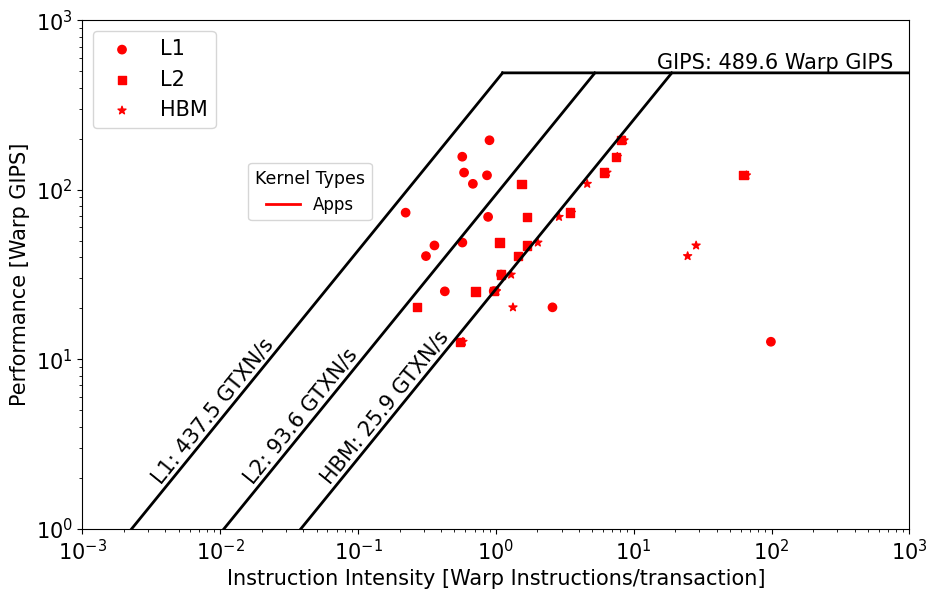

In [65]:
roofline(LABELS=pruned_th.dataframe["name"].tolist(), flag='all', data_df=agg_df)

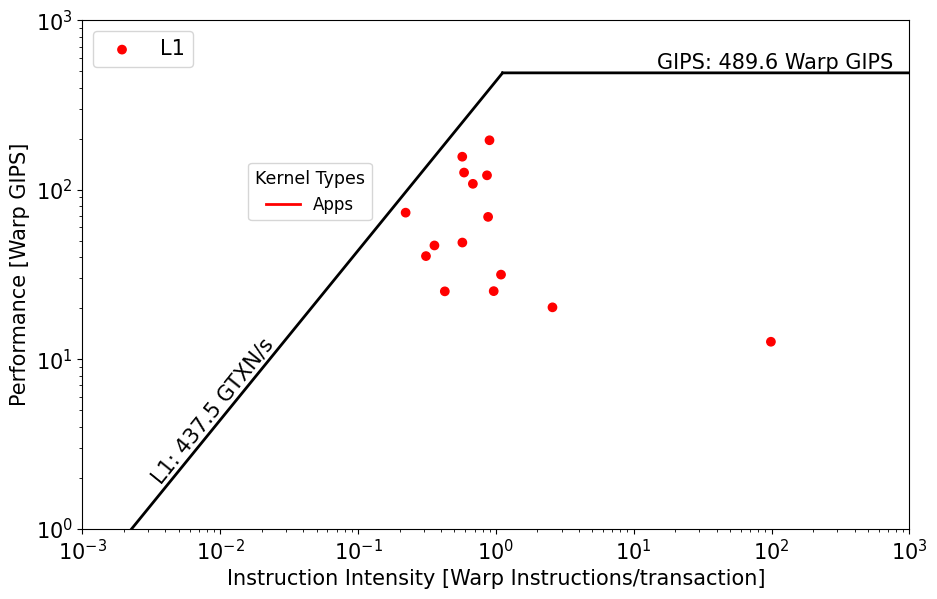

In [66]:
roofline(LABELS=pruned_th.dataframe["name"].tolist(), flag='L1', data_df=agg_df)

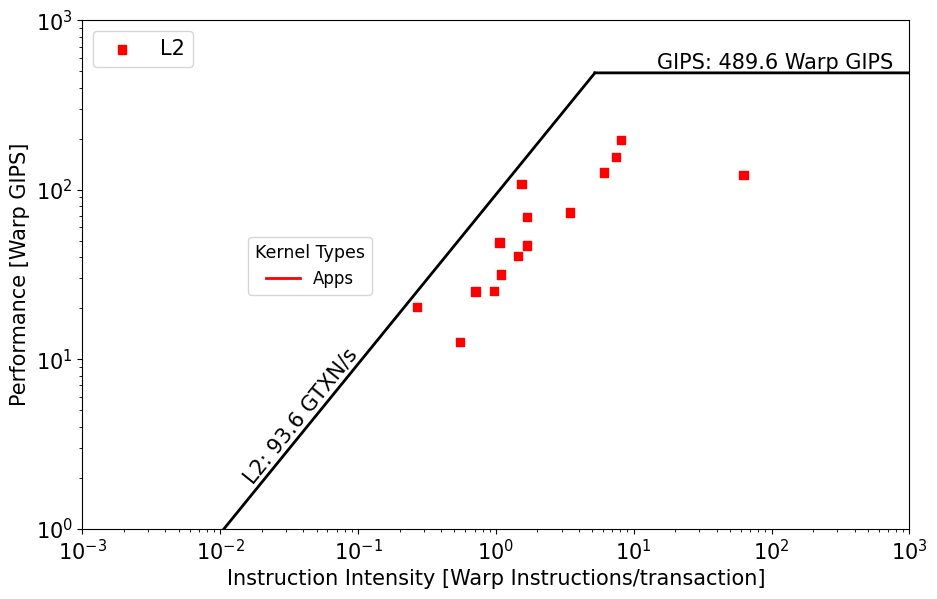

In [67]:
roofline(LABELS=pruned_th.dataframe["name"].tolist(), flag='L2', data_df=agg_df)

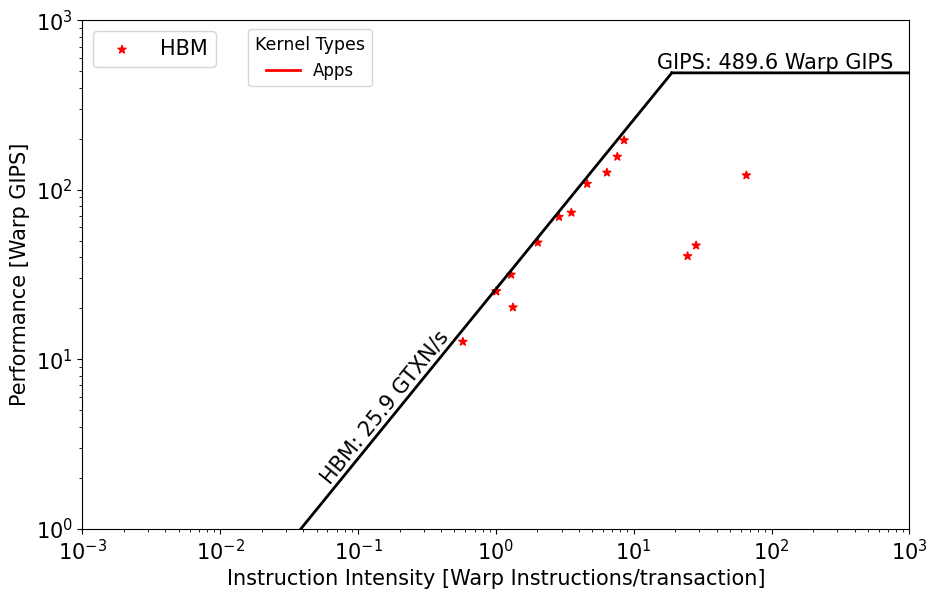

In [68]:
roofline(LABELS=pruned_th.dataframe["name"].tolist(), flag='HBM', data_df=agg_df)